In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

print('setup complete')

setup complete


In [2]:
# Use GPU if available else use CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
#Taking the dataset directly from torchvision

train_data = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))

test_data = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  


In [4]:
#create trainloader and testloader
trainloader =  torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
testloader =   torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)

trainloader

In [5]:
# get better understanding

# def imshow(image, ax=None, title=None, normalize=True):
#     """Imshow for Tensor."""
#     if ax is None:
#         fig, ax = plt.subplots()
#     image = image.numpy().transpose((1, 2, 0))

#     if normalize:
#         mean = np.array([0.485, 0.456, 0.406])
#         std = np.array([0.229, 0.224, 0.225])
#         image = std * image + mean
#         image = np.clip(image, 0, 1)

#     ax.imshow(image)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.tick_params(axis='both', length=0)
#     ax.set_xticklabels('')
#     ax.set_yticklabels('')

#     return ax

# Run this to test your data loaders
# images, labels = next(iter(trainloader))
# print(images, labels)
# imshow(images[1], normalize=False)
# imshow(images[2], normalize=False)


labels of this image is:  9
torch.Size([1, 28, 28])


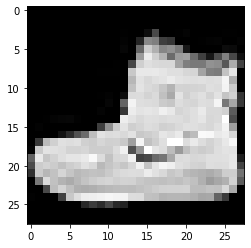

In [6]:
#alternative way to show single image but with less code
image, label = next(iter(train_data))
plt.imshow(image.squeeze(), cmap="gray")
print('labels of this image is: ', label)

image,label=train_data[0]
print(image.shape)

#output shape is 1 which means its a grayscale

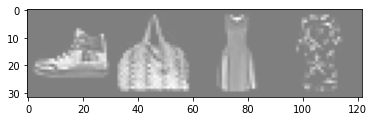

In [7]:
#alternative code to show images but a grid of them
def imshow(img):
    img=img/2+0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
dataiter=iter(trainloader)
images,labels=dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [8]:
#This is a sequential API approach, creating a class would be 

model = nn.Sequential(
    #First COnv2d
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    # ((28 - 3(kernel size) + 2 * 1(padding))/ s (stride)) + 1
    # the dimension of the image after first conv2d is  28*28
    nn.ReLU(),
    
    nn.MaxPool2d(2, 2),
    # after this the dimension of the image would be  14*14

    #Second Conv2d
    nn.Conv2d(32, 64, kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    
    nn.Flatten(),
    
    #First venilla layer
    nn.Linear(64*14*14, 1024), #we can choose this 1024 neurons
    nn.ReLU(),
    
    #second venilla layer
    nn.Linear(1024, 512),
    nn.ReLU(),
    
    nn.Linear(512,10))

In [9]:
# Class with sequential API

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=1024)
        #self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=10)
        
        
    def forward(self, x):
        #in forward function, we define how our data flows through these layers
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.size(0), -1)
        #out = nn.Flatten()
        #out = self.drop_out(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.softmax(out, dim=1)
        return out

model = CNN()
model

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)

In [10]:
#define the optimizer and the loss
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.NLLLoss()

print('Initial weights - ', model.fc1.weight)

images, labels = next(iter(trainloader))

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()

print('Gradient -', model.fc1.weight.grad)
optimizer.step()

Initial weights -  Parameter containing:
tensor([[-0.0155, -0.0013,  0.0073,  ..., -0.0118, -0.0141,  0.0055],
        [-0.0021, -0.0157, -0.0137,  ..., -0.0057,  0.0203,  0.0005],
        [ 0.0168,  0.0005,  0.0035,  ...,  0.0175, -0.0163, -0.0163],
        ...,
        [-0.0162, -0.0141,  0.0014,  ...,  0.0046,  0.0186, -0.0015],
        [-0.0014,  0.0180,  0.0095,  ...,  0.0059, -0.0168, -0.0105],
        [-0.0096,  0.0190,  0.0006,  ...,  0.0084,  0.0093, -0.0007]],
       requires_grad=True)
Gradient - tensor([[-2.7065e-05, -3.4256e-05, -5.1555e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.8641e-06,  1.4674e-06,  1.5817e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.2430e-05, -1.2386e-05, -2.9460e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.7341e-05,  4.3163e-05,  7.7808e-05,  ...,  0.0000e

In [12]:
epochs = 3
print_every = 40

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):

        # Flatten MNIST images into a 784 long vector
        #images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0 

Epoch: 1/3
	Iteration: 0	 Loss: -0.0025
	Iteration: 40	 Loss: -0.1004
	Iteration: 80	 Loss: -0.1007
	Iteration: 120	 Loss: -0.1002
	Iteration: 160	 Loss: -0.1000
	Iteration: 200	 Loss: -0.1001
	Iteration: 240	 Loss: -0.1003
	Iteration: 280	 Loss: -0.1007
	Iteration: 320	 Loss: -0.1007
	Iteration: 360	 Loss: -0.1004
	Iteration: 400	 Loss: -0.1006
	Iteration: 440	 Loss: -0.1008
	Iteration: 480	 Loss: -0.1010
	Iteration: 520	 Loss: -0.1015
	Iteration: 560	 Loss: -0.1009
	Iteration: 600	 Loss: -0.1011
	Iteration: 640	 Loss: -0.1014
	Iteration: 680	 Loss: -0.1011
	Iteration: 720	 Loss: -0.1018
	Iteration: 760	 Loss: -0.1012
	Iteration: 800	 Loss: -0.1012
	Iteration: 840	 Loss: -0.1013
	Iteration: 880	 Loss: -0.1018
	Iteration: 920	 Loss: -0.1014
	Iteration: 960	 Loss: -0.1020
	Iteration: 1000	 Loss: -0.1020
	Iteration: 1040	 Loss: -0.1024
	Iteration: 1080	 Loss: -0.1021
	Iteration: 1120	 Loss: -0.1021
	Iteration: 1160	 Loss: -0.1022
	Iteration: 1200	 Loss: -0.1024
	Iteration: 1240	 Loss: -0

	Iteration: 10280	 Loss: -0.7373
	Iteration: 10320	 Loss: -0.5964
	Iteration: 10360	 Loss: -0.7578
	Iteration: 10400	 Loss: -0.6182
	Iteration: 10440	 Loss: -0.6449
	Iteration: 10480	 Loss: -0.6671
	Iteration: 10520	 Loss: -0.6200
	Iteration: 10560	 Loss: -0.6762
	Iteration: 10600	 Loss: -0.7020
	Iteration: 10640	 Loss: -0.6956
	Iteration: 10680	 Loss: -0.6596
	Iteration: 10720	 Loss: -0.6726
	Iteration: 10760	 Loss: -0.6446
	Iteration: 10800	 Loss: -0.7365
	Iteration: 10840	 Loss: -0.6922
	Iteration: 10880	 Loss: -0.7467
	Iteration: 10920	 Loss: -0.7664
	Iteration: 10960	 Loss: -0.6387
	Iteration: 11000	 Loss: -0.6770
	Iteration: 11040	 Loss: -0.7105
	Iteration: 11080	 Loss: -0.6891
	Iteration: 11120	 Loss: -0.6876
	Iteration: 11160	 Loss: -0.7318
	Iteration: 11200	 Loss: -0.7137
	Iteration: 11240	 Loss: -0.6981
	Iteration: 11280	 Loss: -0.6486
	Iteration: 11320	 Loss: -0.6993
	Iteration: 11360	 Loss: -0.7406
	Iteration: 11400	 Loss: -0.6708
	Iteration: 11440	 Loss: -0.7364
	Iteration

KeyboardInterrupt: 